# 1. Perkenalan
---
- Nama: Julius William
- Batch: HCK - 033
- Objektif: Objektif utama dari Tugas ini adalah untuk membuat sebuah model dengan arsitektur ANN/ CNN. Arsitektur ANN dan CNN dapat digunakan untuk melakukan banyak hal, tapi yang akan dilakukan pada tugas ini adalah untuk mengklasifikasikan ras kucing berdasarkan gambar yang diberikan. Jadi hal yang pertama dilakukan adalah untuk membuat sebuah model dengan ANN dan melatihnya dengan gambar-gambar kucing dengan ras yang beda-beda. Tujuan dari model ini adalah untuk membantu pasar jual beli kucing, karena kucing adalah salah satu hewan dengan banyak ras yang berbeda dan mirip-mirip satu sama lain. Selain itu akan dilakukan berbaikan model ANN/CNN yang dibuat. Ada beberapa hal yang dapat digunakan untuk lah ini, salah satunya adalah transfer learning yang dimana menggunakan model yang sudah ada dan jauh lebih kompleks dan di implimentasikan ke model kita agar dapat meningkatkan hasil kita.
---

# 2. Import Libraries

In [22]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from PIL import Image

# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.preprocessing import LabelEncoder

# 3. Data Loading

Pada bagian ini akan dilakukan data loading. Pada awalnya data yang digunakan berbentuk 5 folder yang berbeda dimana masing-masing folder berisi ras kucing yang berbeda-beda. Tapi disini akan digabungkan menjadi satu datafram dengan 2 kolom yaitu path gambar dan label (ras kucing).

In [2]:
base_path = "Cat_Data"

data = []

# loop through each class folder
for label in os.listdir(base_path):
    class_folder = os.path.join(base_path, label)

    # Skip non-directories
    if not os.path.isdir(class_folder):
        continue

    # Loop through files in the class folder
    for file_name in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file_name)

        # Skip non-images (optional: check extensions)
        if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            continue

        data.append({
            'image_path': file_path,
            'label': label
        })

# Convert to DataFrame
data = pd.DataFrame(data)
data.head()

image_path   label
0      Cat_Data\bengal\00438-Bengal-cat-snarling.jpg  bengal
1  Cat_Data\bengal\00441-Very-timid-Brown-Spotted...  bengal
2  Cat_Data\bengal\00e79f939696ea0c095603154c4af8...  bengal
3  Cat_Data\bengal\03915-Pair-of-Bengal-kittens-w...  bengal
4  Cat_Data\bengal\04413-Bengal-cat-white-backgro...  bengal

Dapat dilihat bahwa datafram 'data' sudah berhasil dibuat. Hal ini akan membantu kita untuk melakukan data spliting menjadi data train, validation dan test.

# 4. EDA

## 4.1 Distribusi Jenis Kucing

Pada bagian ini akan dilihat apakah distribusi dari jenis kucingnya uniform (merata) atau tidak. Hasil dari pemeriksaan ini akan digunakan untuk langkah-langkah kedepannya.

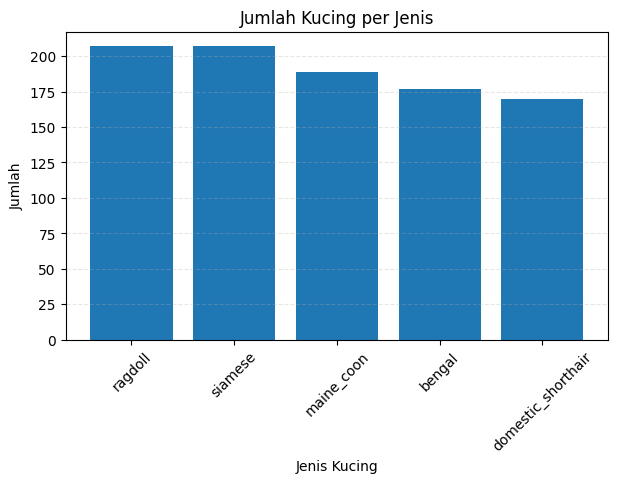

In [3]:
# Hitung jumlah per label
label_counts = data['label'].value_counts()

# Plot
plt.figure(figsize=(7,4))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Jenis Kucing')
plt.ylabel('Jumlah')
plt.title('Jumlah Kucing per Jenis')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

Dapat dilihat dari grafik diatas bahwa distribusi dari data sudah lumayan merata, sehingga tidak butuh dilakukan data balancing.

## 4.2 Dimensi Gambar

Dimensi gambar (pixels) akan diperiksa terlebih dahulu agar kedepanya dapat dilihat ukur optimal untuk pemodelan berapa.

In [4]:
for lbl in data['label']:
    class_path = os.path.join(base_path, lbl)
    img_files = os.listdir(class_path)[:1]  # Cek 1 gambar per class
    if img_files:
        img = Image.open(os.path.join(class_path, img_files[0]))
        print(f"{lbl}: {img.size} (format: {img.format})")

bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format: JPEG)
bengal: (1120, 1104) (format

In [5]:
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        sizes = []
        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        sizes = np.array(sizes)
        mean_w, mean_h = sizes.mean(axis=0)
        print(f"{class_name}: rata-rata {mean_w:.1f} x {mean_h:.1f} pixels")

bengal: rata-rata 1913.6 x 1598.4 pixels
domestic_shorthair: rata-rata 2084.3 x 1971.9 pixels
maine_coon: rata-rata 1711.8 x 1676.4 pixels
ragdoll: rata-rata 1855.3 x 1722.7 pixels
siamese: rata-rata 2031.4 x 1796.7 pixels


Dapat dilihat dari hasil diatas rata-rata ukuran gambarnya adalah sekitar 1700x1700, tapi ukuran ini sangat lah besar sehingga setelah melakukan beberapa percobaan didapatkan ukuran yang digunakan adalah 224x224. Ukuran ini sudah kucup baik dalam menampilkan gambar-gambar yang ada.

## 4.3 Ciri-Ciri Jenis Kucing

### 4.3.1 Bengal

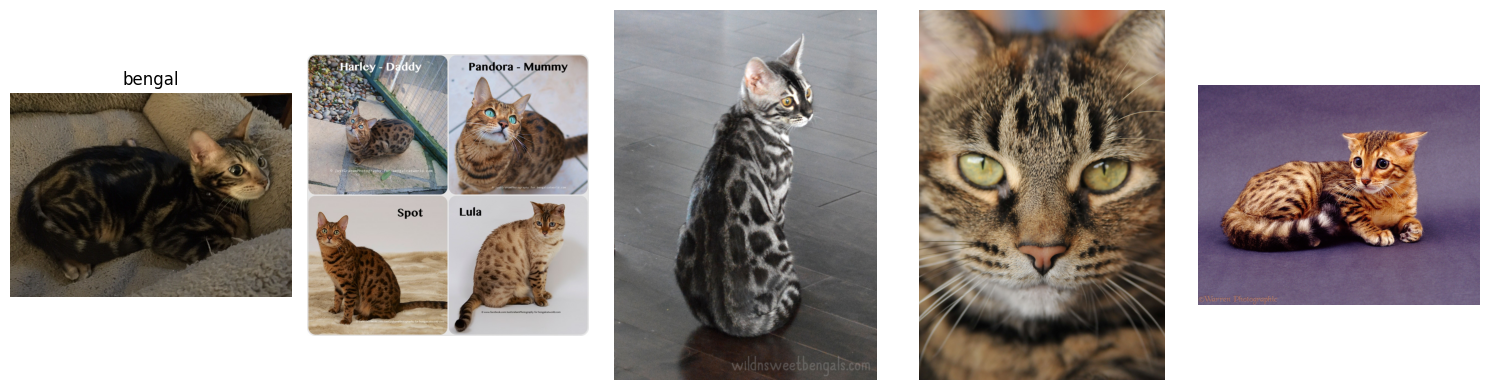

In [6]:
labels = ["bengal"]

for i in labels:
    num_samples = 5
    fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

    # Jika hanya 1 baris → jadikan axes 2D
    if len(labels) == 1:
        axes = axes.reshape(1, num_samples)

    for row, lbl in enumerate(labels):
        class_folder = os.path.join(base_path, lbl)

        img_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]

        sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

        for col, img_file in enumerate(sample_imgs):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path)

            axes[row, col].imshow(img)
            axes[row, col].set_title(lbl if col == 0 else "")
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Bengal: Kucing bengal adalah salah satu jenis kucing yang memiliki penampilan unik. Kucinng bengal memiliki pola yang membedangan dengan jenis kucing-kuncing lainnya. Mereka memiliki pola bulat-bulat hitam atau strip yang membuatnya mirip seperti macan, terutama macan tutul.

### 4.3.2 Domestic Shorthair

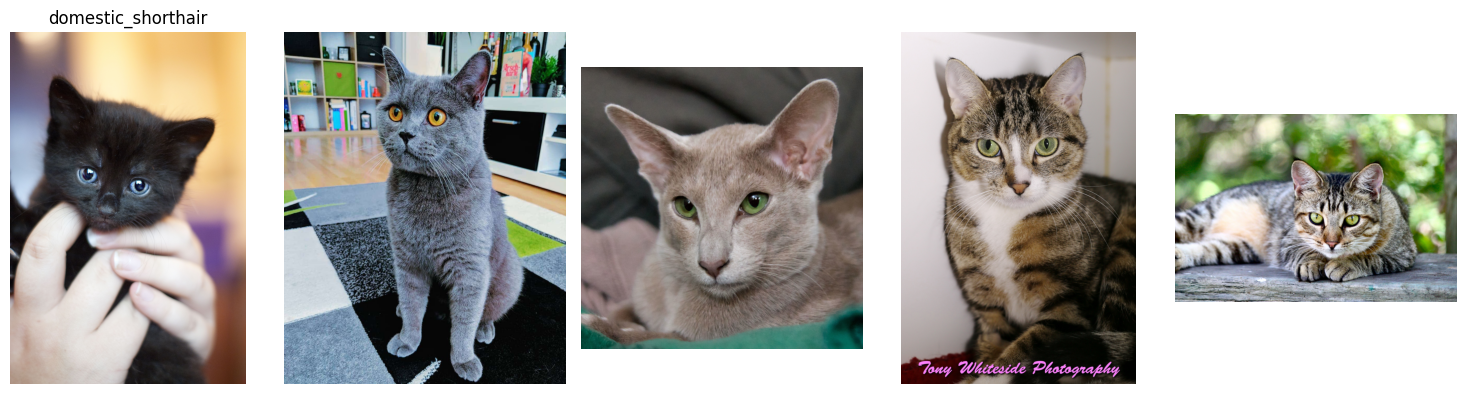

In [7]:
labels = ["domestic_shorthair"]

for i in labels:
    num_samples = 5
    fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

    # Jika hanya 1 baris → jadikan axes 2D
    if len(labels) == 1:
        axes = axes.reshape(1, num_samples)

    for row, lbl in enumerate(labels):
        class_folder = os.path.join(base_path, lbl)

        img_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]

        sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

        for col, img_file in enumerate(sample_imgs):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path)

            axes[row, col].imshow(img)
            axes[row, col].set_title(lbl if col == 0 else "")
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Domestic Shorthair: Kucing domestic shorthair adalah kucing rumahan yang paling umum. Kucing ini memiliki bulu yang pendek dan memiliki banyak warna dan pola. Berikut adalah beberapa pola yang dapat dimiliki kucing domestic shorthair:
- Tuxedo
- Calico
- Tabby
- Orange
- Putih
- Hitam
- Dkk

Dapat dibilang domestic short hair adalah kucing yang tidak memiliki ras murni sehingga memiliki banyak pola danwaran yang berbeda.

### 4.3.3 Maine Coon

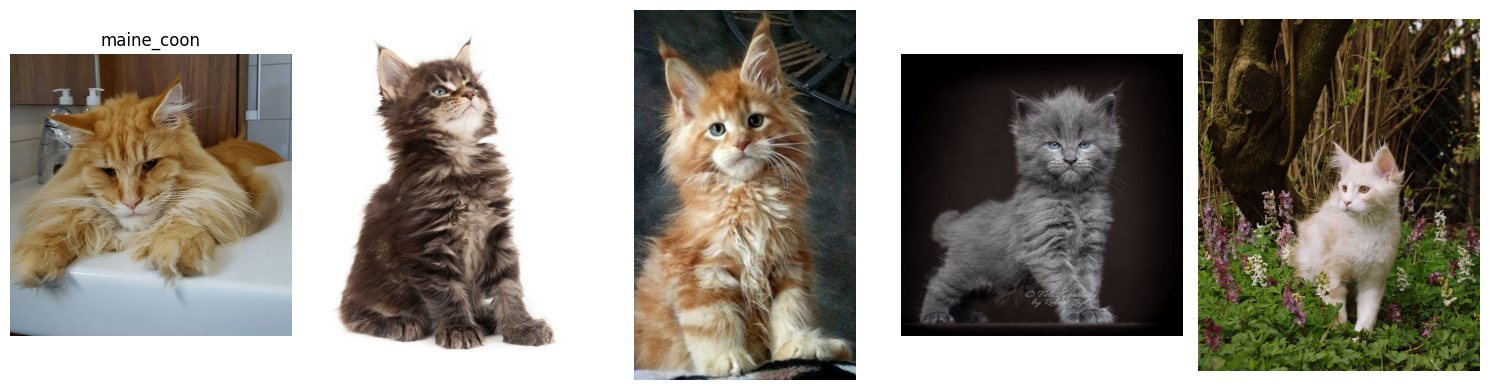

In [8]:
labels = ["maine_coon"]

for i in labels:
    num_samples = 5
    fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

    # Jika hanya 1 baris → jadikan axes 2D
    if len(labels) == 1:
        axes = axes.reshape(1, num_samples)

    for row, lbl in enumerate(labels):
        class_folder = os.path.join(base_path, lbl)

        img_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]

        sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

        for col, img_file in enumerate(sample_imgs):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path)

            axes[row, col].imshow(img)
            axes[row, col].set_title(lbl if col == 0 else "")
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Maine Coon: Kucing maine coon adalah salah satu ras kucing yang terbesar di dunia. Maine coon memiliki bulu yang cenderung panjang dam memiliki telinga yang tinggi dan besar dibandingkan kucing pada umumnya. Selain itu, bentuk kepala maine coon menjadi salah satu fitur yang membedakan dengan kucing lainnya yaitu muzzle kotak. Dapat dilihat bahwa dari hidung ke mulutnya membentuk kotak dan itu menjadi salah satu ciri khas ras maine coon. Lalu, dapat dikatakan bahwa maine coon memeiliki badan yang kuat dan berotot, sehingga memberi bentuk badan yang tidak seperti kucing pada umumnya.

### 4.3.4 Ragdoll

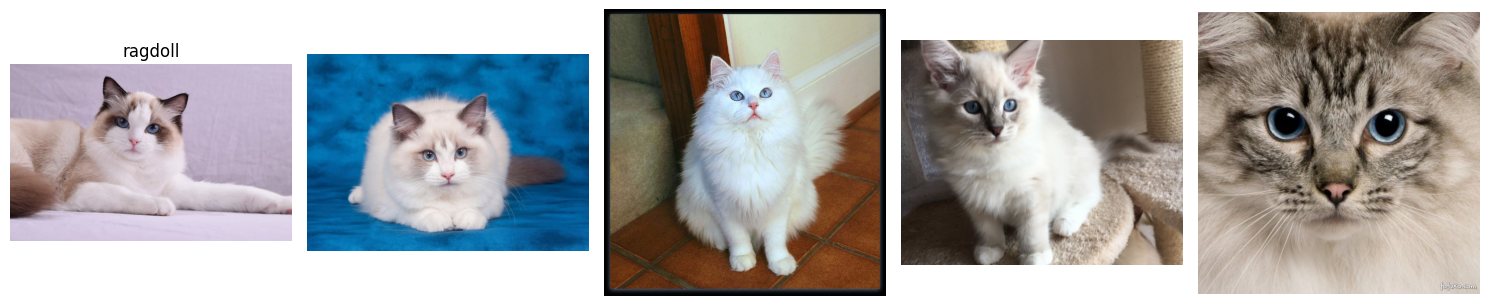

In [9]:
labels = ["ragdoll"]

for i in labels:
    num_samples = 5
    fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

    # Jika hanya 1 baris → jadikan axes 2D
    if len(labels) == 1:
        axes = axes.reshape(1, num_samples)

    for row, lbl in enumerate(labels):
        class_folder = os.path.join(base_path, lbl)

        img_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]

        sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

        for col, img_file in enumerate(sample_imgs):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path)

            axes[row, col].imshow(img)
            axes[row, col].set_title(lbl if col == 0 else "")
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Ragdoll: Kucing ragdoll adalah ras kucing yang berukuran besar, memiiliki bulu panjang dan bulu yang sangat lembut. Beda dengan maine coon, ragdoll lebih membulat dan lebih lemas. Salah satu hal yang membua unik ras ragdoll adalah warna mata yang selalu biru. Hall-hal ini membuat pandampilan ragdoll lucu dan cantik.

### 4.3.5 Siamese

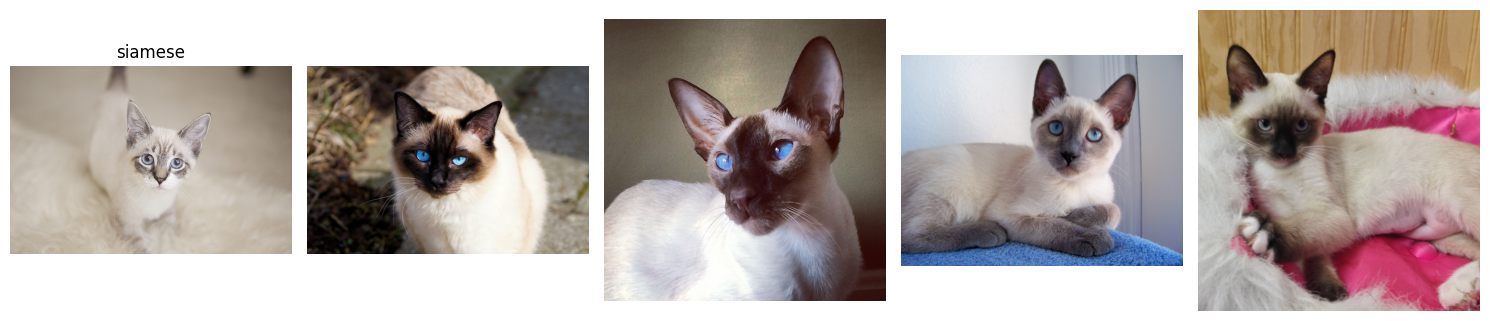

In [10]:
labels = ["siamese"]

for i in labels:
    num_samples = 5
    fig, axes = plt.subplots(len(labels), num_samples, figsize=(15, 4))

    # Jika hanya 1 baris → jadikan axes 2D
    if len(labels) == 1:
        axes = axes.reshape(1, num_samples)

    for row, lbl in enumerate(labels):
        class_folder = os.path.join(base_path, lbl)

        img_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        ]

        sample_imgs = random.sample(img_files, min(num_samples, len(img_files)))

        for col, img_file in enumerate(sample_imgs):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path)

            axes[row, col].imshow(img)
            axes[row, col].set_title(lbl if col == 0 else "")
            axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

Siamese: Kucing siamese memiliki muka yang denderung panjang dan seperti segitiga. Selain itu, siamese memiliki terling tinggi dan lebar di dasarnya. Siamese memiliki pola warna colorpoint yang berarti mukanya memiliki warna yang lebih gelap dobandingkan badannya. Dan salah satu fitur yang membadakan siamese adalah mata yang biru.

# 5. Feature Engineering 

Sebelum kita dapat melakukan pemodelan, akan dilakukan beberapa feature engineering terhadap datanya.

## 5.1 Data Split

Disini akan dilakukan data spliting, akan dijadikan data train dan test terlebih dahulu. Karena data yang dimiliki tidak terlalu banyak (sekitar 950), data ukuran data testnya adalah 20%.

In [11]:
IMG_SIZE=224

X = data.drop('label', axis=1)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=67
)

In [12]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=67)

Data sudah berhasil dibagi menjadi data train dan test.

## 5.2 Data Augmentation

Berikutnya akan dilakukan data augmentation. Guna dari data augmentation adalah untuk memodifikasi gambar-gambar yang kita miliki agar model dapat berlatih dengan gambar-gambar yang bervariasi. Dan pada proses ini akan dilakukan meisahan data train menjadi data train dan validation. Dan pembagiannya adalah 60% train dan 40% validasi.

Found 456 validated image filenames belonging to 5 classes.
Found 304 validated image filenames belonging to 5 classes.


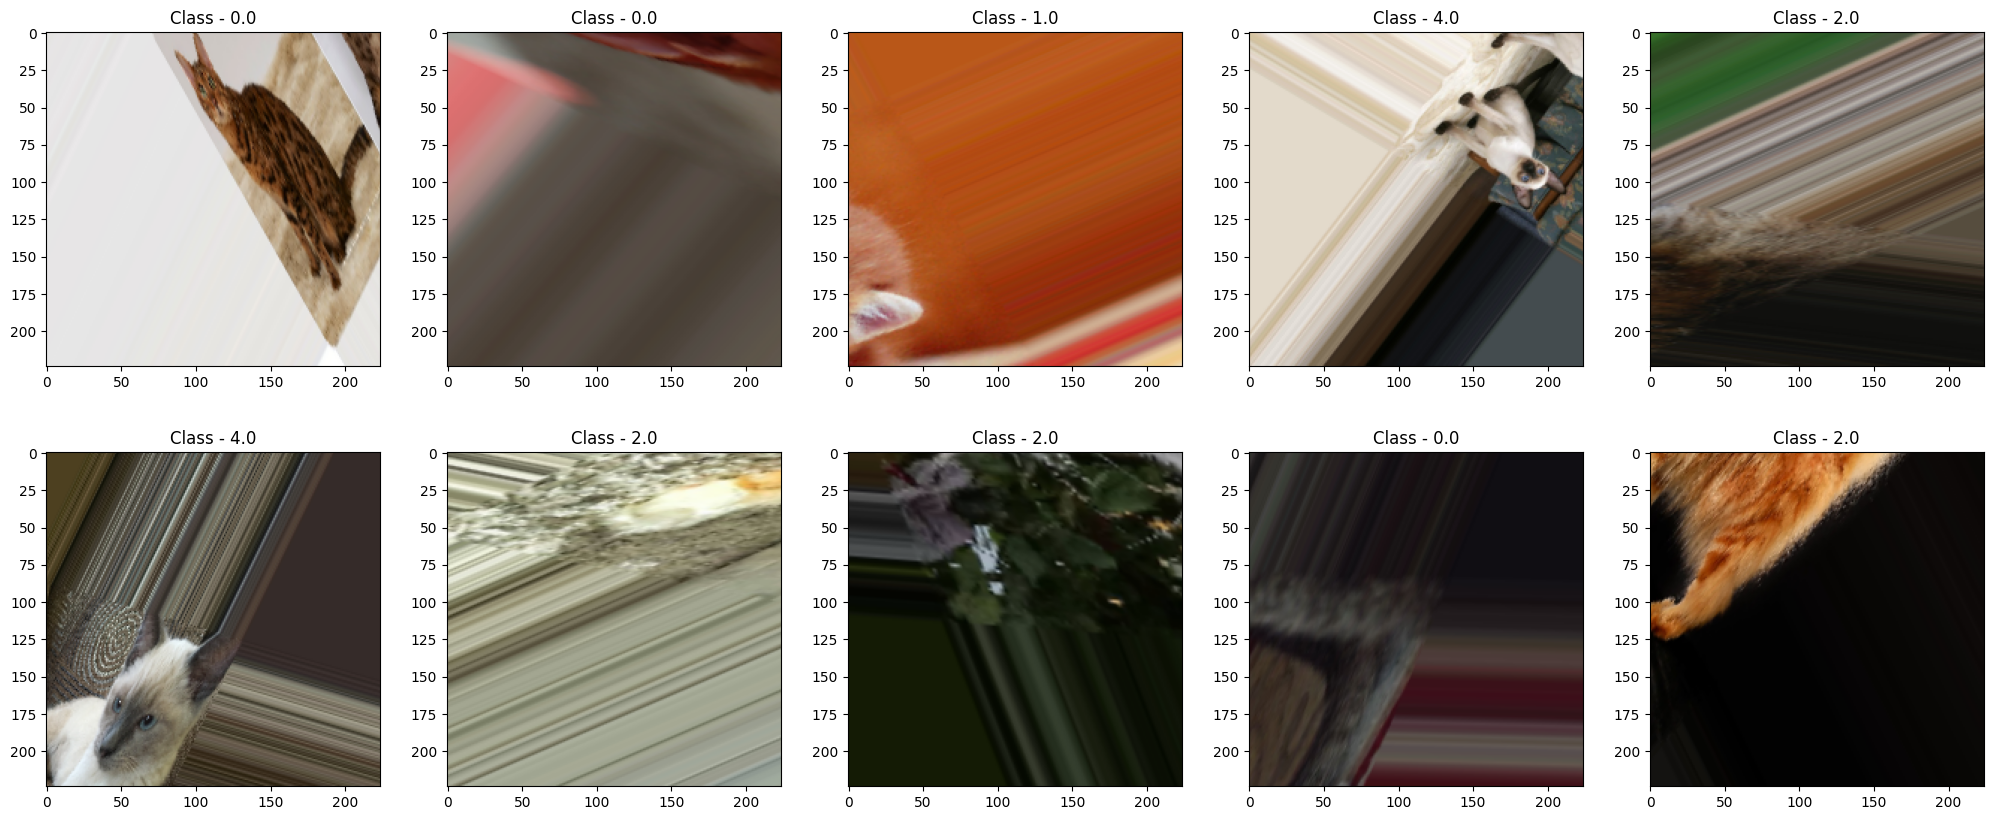

In [13]:
imgen3 = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-100, 100],
                                                         height_shift_range=[-100, 100],
                                                         rotation_range=120,
                                                         zoom_range = [0.3, 1.5],
                                                         shear_range=50,
                                                         validation_split=0.4)
train = imgen3.flow_from_dataframe(train_df,
                                    target_size=(IMG_SIZE,IMG_SIZE),
                                    x_col='image_path',
                                    y_col='label',
                                    class_mode='sparse',
                                    subset='training',
                                    shuffle=True,
                                    seed=67)
val = imgen3.flow_from_dataframe(train_df,
                                  target_size=(IMG_SIZE,IMG_SIZE),
                                  x_col='image_path',
                                  y_col='label',                          
                                  class_mode='sparse',
                                  subset='validation',
                                  shuffle=True,
                                  seed=67)

# Show images of train-set
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))
n = 0

for i in range(2):
  for j in range(5):
    img = train[0][0][n].astype('uint8')
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(train[0][1][n]))
    n += 1

Data sudah berhasil dilakukan data agumentation dan spliting menjadi train dan validation. Dapat dilihat pada gambar diatas gambar sudah bervariasi.

# 6. CNN 

CNN atau Convolutional Neural Network adalah pengembangan dari ANN, dimana ditambah lapisan kusus untuk dapat membaca pola dari gambar-gambar. Sehingga CNN lebih cocok untuk hal seperti megolah foto ataupun video.

## 6.1 Model Definition

Pada bagian ini akan digunakan

In [14]:
seed = 67
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(6, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,399,174 (169.37 MB)

 Trainable params: 44,399,174 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

## 6.2 Model Training

Model akan dilakukan traning dan akan digunakan epochs=20.

In [16]:
history_aug = model_aug.fit(train, epochs=20, validation_data=val, batch_size=32)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.1900 - loss: 388.8851 - val_accuracy: 0.1842 - val_loss: 3.8176
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2050 - loss: 2.4266 - val_accuracy: 0.2303 - val_loss: 1.8017
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2237 - loss: 1.7786 - val_accuracy: 0.2237 - val_loss: 1.7679
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2036 - loss: 1.9682 - val_accuracy: 0.1842 - val_loss: 1.7677
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1918 - loss: 1.7651 - val_accuracy: 0.2072 - val_loss: 1.7360
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2241 - loss: 1.7107 - val_accuracy: 0.2303 - val_loss: 1.7094
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2404 - loss: 1.7081 - val_accuracy: 0.2303 - val_loss: 1.6899
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2322 - loss: 1.6830 - val_accuracy: 0.2434 - val_los

Dapat dilihat dari hadil diiatas model ini memiliki accuracy 23%. Dapat dikatakan bahwa model ini kurang bisa menangkap pola dari ras-ras kucing. Hal ini masuk akal karena ras-ras kucing tidak jauh berbeda dari satu sama lain.

## 6.3 Model Evaluation

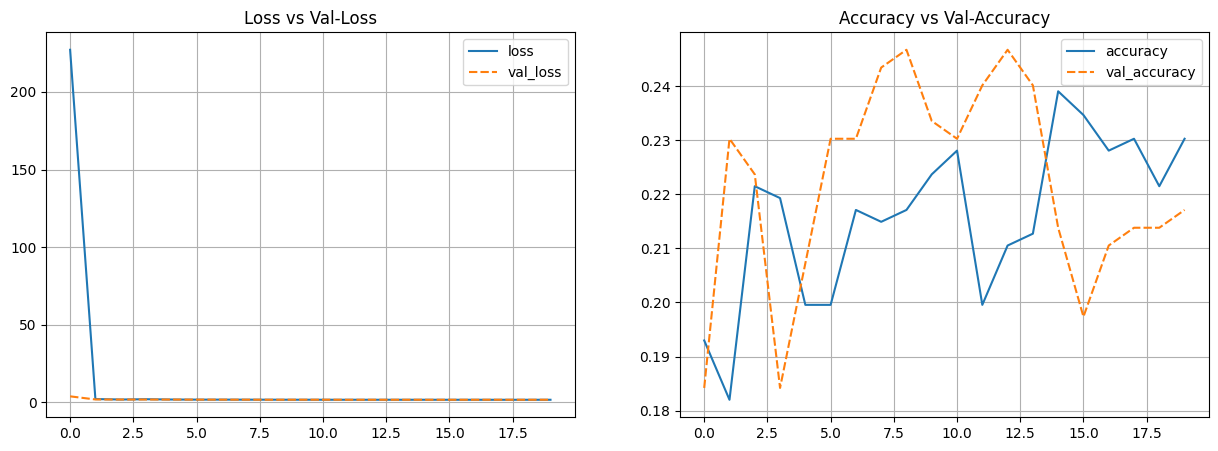

In [17]:
history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Grafik diatas menggambarkan Accurasi terhadap berjalannya epoch.

# 7. CNN Improve

Denagn tujuan untuk meningkatkan model pada bagian 6, akan dicoba menggunakan trasfer learning untuk membuat model lebih baik. Disini akan digunakan model EfficientNetB0. EfficientNet adalah model dengan efficency yang tinggi, sehingga dapat menghasilkan akurasi tinggi dengan parameter yang lebih rendah.

## 7.1 Model Definition

In [18]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D

# Load pretrained EfficientNetB0
pretrained_effnet = EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
pretrained_effnet.trainable = False   # freeze pretrained layers

# Build model with Sequential API
model = Sequential()
model.add(pretrained_effnet)
model.add(GlobalAveragePooling2D())     # lebih bagus dari Flatten
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,708,521 (17.96 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Dapat dilihat bahwa total parameter dari model diatas hanya 4 708 521. Angka ini sangat lah kecil dibandingkan model pada bagian 6, ini akan membuat model lebih ringan ketika berjalan.

## 7.2 Model Training

In [19]:
history_model = model.fit(train, epochs=20, validation_data=val, batch_size=32)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2847 - loss: 1.6569 - val_accuracy: 0.4112 - val_loss: 1.4123
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5347 - loss: 1.1873 - val_accuracy: 0.4539 - val_loss: 1.3254
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5389 - loss: 1.1990 - val_accuracy: 0.4901 - val_loss: 1.2217
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5115 - loss: 1.2310 - val_accuracy: 0.4704 - val_loss: 1.2377
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5551 - loss: 1.1505 - val_accuracy: 0.5395 - val_loss: 1.1565
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5363 - loss: 1.1039 - val_accuracy: 0.5263 - val_loss: 1.2297
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5512 - loss: 1.1229 - val_accuracy: 0.5230 - val_loss: 1.1490
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5905 - loss: 1.0401 - val_accuracy: 0.4934 - val_loss:

Dapat dilihat dari hasil diatas model ini dapat menghasilkan akurasi yang cukup bagus jika dibandingkan dengan model pada bagian 6.

## 7.3 Model Evaluation

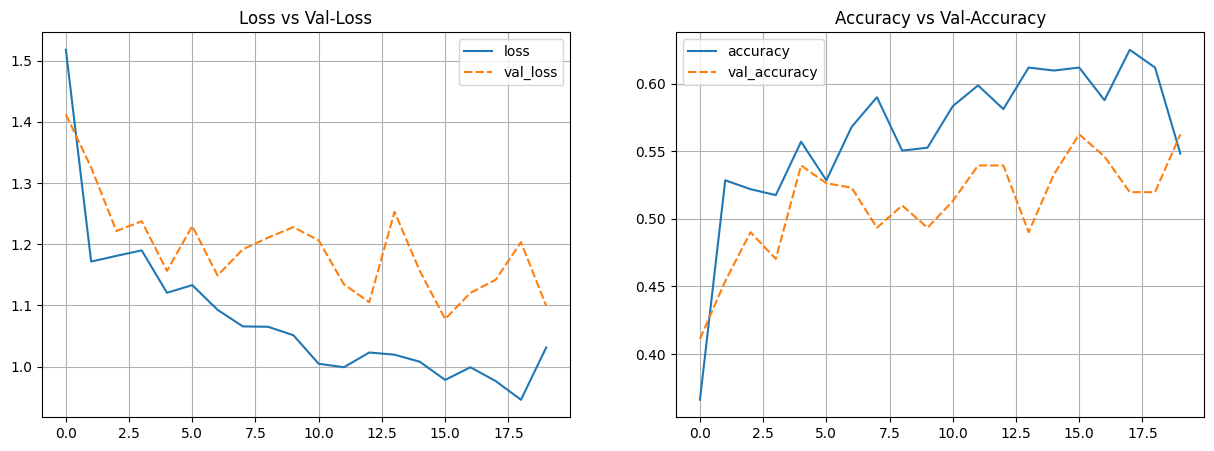

In [20]:
history_model_df = pd.DataFrame(history_model.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

# 8. Model Terbaik

Model yang terbaik dari 2 model diatas adalah model dengan trasfer learning EfficientNet. Model tersebut lebih baik dari segi jumlah parameter dan juga akurasi.

## 8.1 Data Preperation

Disini akan dilakukan persiapan pada data test agar dapat dilakukan clasification report. Hal yang dilakuakn adalah untuk mengubah path photo menjadi hal yang bisa dibaca oleh model, dan targetnya dibuah menjadi angka dengan label encoder.

In [23]:
X_test_arr = np.array([
    preprocess_input(
        img_to_array(
            load_img(p, target_size=(IMG_SIZE, IMG_SIZE))
        )
    )
    for p in X_test["image_path"]
], dtype="float32")

In [24]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test) 

In [25]:
y_pred = np.argmax(model.predict(X_test_arr), axis=1)
print(classification_report(y_test_encoded, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        42
           1       0.69      0.81      0.74        36
           2       0.74      0.86      0.80        37
           3       0.80      0.74      0.77        38
           4       0.82      0.76      0.79        37

    accuracy                           0.79       190
   macro avg       0.80      0.79      0.79       190
weighted avg       0.80      0.79      0.80       190



Dari hasil diatas dapat dilihat model dapat melakukan prediksi dengan akurasi 80%. Hal ini sangat memuaskan karena pada evaluasi hanya dapat prediksi dengan akurasi 60%.

# 9. Model Saving

In [26]:
model.save('best_model.keras')

# 10. Model Inference

Model inference dilakukan pada notebook "P2G7_julius_william_inf.ipynb"

# 11. Kesimpulan

Setelah melakukan tugas ini, ada beberapa hal yang dapat disimpulkan. Pertama, kucing adalah salah satu hewan yang paling sulit dilakuakn klasifikasi, hal ini terjadi karena kemiripan bentuk bandan kucing yang ada di semua ras kucing. Kedua, dengan menggunakan model EfficentNet pada transfer learning, model dapat menjadi lebih akurat dan efisien. Sehingga untuk klasifikas gambar dapat menggunakan model ini kembali. Terakhir dalam melakukan inferencing gamabar kucing, model ini dapat mengklasifikasikan kedua gambar dengan batu, yang berarti model sudah cukup bagus menurut saya.